# Custom generators

## A familiar example

Consider the following example which does basic dupin detection using a freud generator,
however, this time we shall read it from a xyz file:

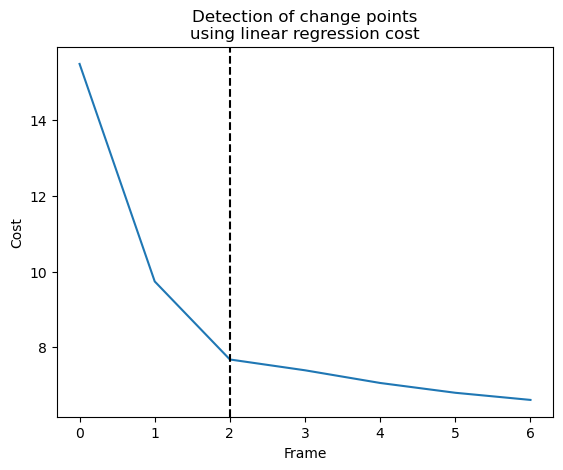

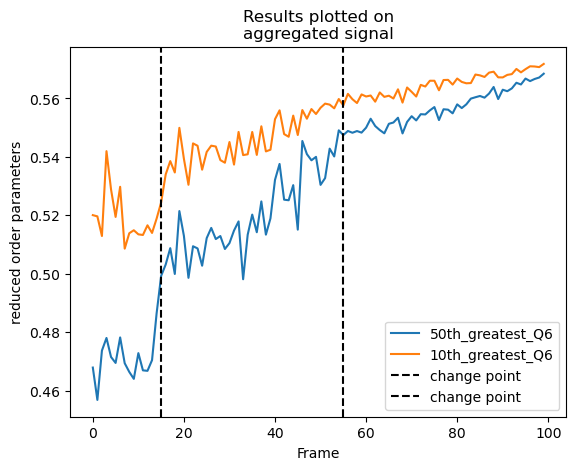

In [1]:
import warnings

import freud
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

import dupin as du

warnings.simplefilter("ignore")
ls = 6
FILENAME = "../data/lj-sim.xyz"
steinhardt = freud.order.Steinhardt(l=ls)
nlist_kwargs = {"num_neighbors": 12, "exclude_ii": True}
pipeline = du.data.freud.FreudDescriptor(
    compute=steinhardt, attrs={"particle_order": f"Q{ls}"}
).pipe(du.data.reduce.NthGreatest((10, 50)))
signal_aggregator = du.data.aggregate.SignalAggregator(pipeline)
with open(FILENAME) as file:
    # Read the number of atoms
    N = int(file.readline().strip())
    # Read the comment line
    comment = file.readline().strip()
    box_params = float_list = [float(x) for x in comment.split()]
box_params = freud.Box.from_box(box_params)
traj = np.genfromtxt(FILENAME, skip_header=2, invalid_raise=False)[
    :, 1:4
].reshape(-1, N, 3)
box = freud.box.Box.cube(L=20)

for frame_positions in traj:
    signal_aggregator.accumulate((box, frame_positions), nlist_kwargs)
lin_regress_cost = du.detect.CostLinearFit()
dynp = rpt.Dynp(custom_cost=lin_regress_cost)
sweep_detector = du.detect.SweepDetector(
    dynp, max_change_points=6, tolerance=0.001
)
change_points = sweep_detector.fit(signal_aggregator.to_dataframe())
plt.plot(sweep_detector.costs_)
plt.title("Detection of change points\nusing linear regression cost")
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.axvline(sweep_detector.opt_n_change_points_, color="k", linestyle="--")
plt.show()
# add change points as vlines
plt.plot(
    signal_aggregator.to_dataframe().to_numpy(),
    label=signal_aggregator.to_dataframe().columns.to_list(),
)
for change_point in change_points:
    plt.axvline(change_point, color="k", linestyle="--", label="change point")
plt.title("Results plotted on\naggregated signal")
plt.xlabel("Frame")
plt.ylabel("reduced order parameters")
plt.legend()
plt.show()

## Custom generator example
Now let's transcribe the above example with a custom generator:

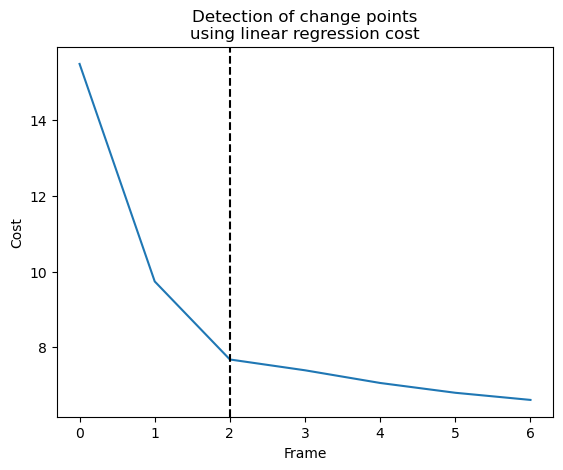

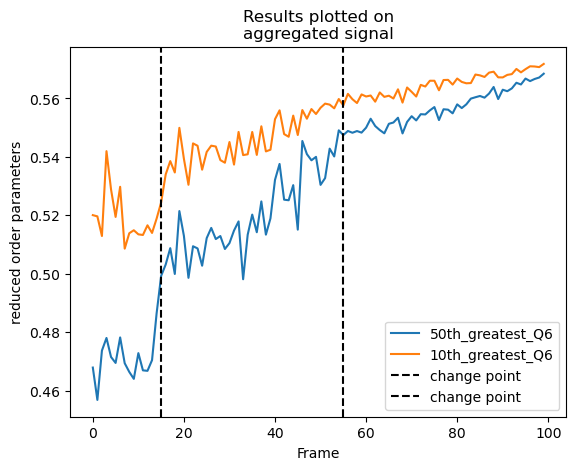

In [2]:
import warnings

import freud
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

import dupin as du

warnings.simplefilter("ignore")
ls = 6
FILENAME = "../data/lj-sim.xyz"


def steinhardt_custom_generator(system):
    steinhardt = freud.order.Steinhardt(l=ls)
    nlist_kwargs = {"num_neighbors": 12, "exclude_ii": True}
    steinhardt.compute(system, neighbors=nlist_kwargs)
    return {f"Q{ls}": steinhardt.particle_order}


pipeline = du.data.base.CustomGenerator(steinhardt_custom_generator).pipe(
    du.data.reduce.NthGreatest((10, 50))
)
signal_aggregator = du.data.aggregate.SignalAggregator(pipeline)
with open(FILENAME) as file:
    # Read the number of atoms
    N = int(file.readline().strip())
    # Read the comment line
    comment = file.readline().strip()
    box_params = float_list = [float(x) for x in comment.split()]
box_params = freud.Box.from_box(box_params)
traj = np.genfromtxt(FILENAME, skip_header=2, invalid_raise=False)[
    :, 1:4
].reshape(-1, N, 3)
box = freud.box.Box.cube(L=20)

for frame_positions in traj:
    signal_aggregator.accumulate((box, frame_positions))
lin_regress_cost = du.detect.CostLinearFit()
dynp = rpt.Dynp(custom_cost=lin_regress_cost)
sweep_detector = du.detect.SweepDetector(
    dynp, max_change_points=6, tolerance=0.001
)
change_points = sweep_detector.fit(signal_aggregator.to_dataframe())
plt.plot(sweep_detector.costs_)
plt.title("Detection of change points\nusing linear regression cost")
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.axvline(sweep_detector.opt_n_change_points_, color="k", linestyle="--")
plt.show()
# add change points as vlines
plt.plot(
    signal_aggregator.to_dataframe().to_numpy(),
    label=signal_aggregator.to_dataframe().columns.to_list(),
)
for change_point in change_points:
    plt.axvline(change_point, color="k", linestyle="--", label="change point")
plt.title("Results plotted on\naggregated signal")
plt.xlabel("Frame")
plt.ylabel("reduced order parameters")
plt.legend()
plt.show()

They are exactly the same! As is expected. The freud generators are convenience
functions for easier handling of freud data.

## A More complicated custom generator example

Now let's try computing two different l's for Steinhardt order parameter using a custom
generator:

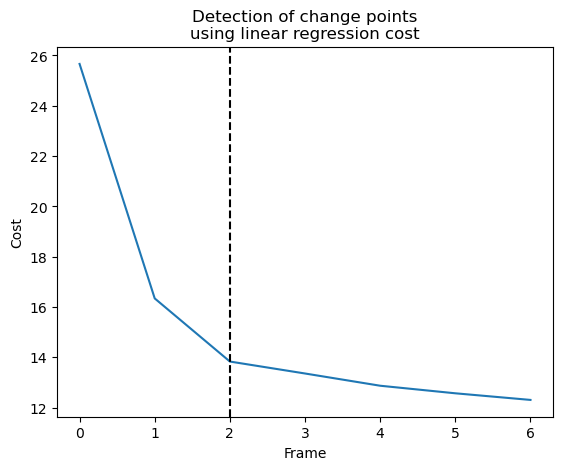

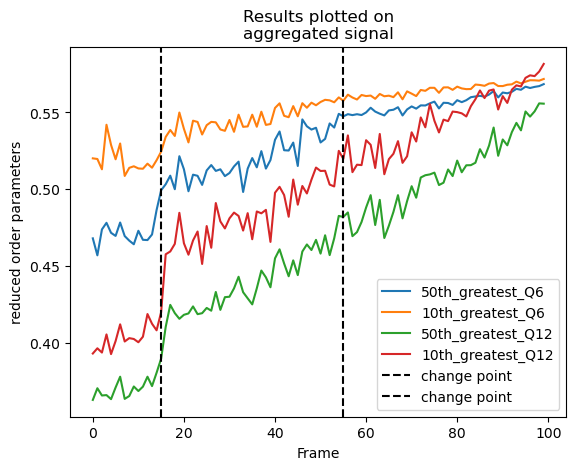

In [3]:
import warnings

import freud
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

import dupin as du

warnings.simplefilter("ignore")
ls = [6, 12]
FILENAME = "../data/lj-sim.xyz"

steinhardt = freud.order.Steinhardt(l=ls)
nlist_kwargs = {"num_neighbors": 12, "exclude_ii": True}


def steinhardt_custom_generator(system):
    steinhardt = freud.order.Steinhardt(l=ls)
    nlist_kwargs = {"num_neighbors": 12, "exclude_ii": True}
    steinhardt.compute(system, neighbors=nlist_kwargs)
    keys = [f"Q{l}" for l in ls]
    properties_dict = {}
    for i, key in enumerate(keys):
        properties_dict[key] = steinhardt.particle_order.T[i]
    return properties_dict


pipeline = du.data.base.CustomGenerator(steinhardt_custom_generator).pipe(
    du.data.reduce.NthGreatest((10, 50))
)
signal_aggregator = du.data.aggregate.SignalAggregator(pipeline)
with open(FILENAME) as file:
    # Read the number of atoms
    N = int(file.readline().strip())
    # Read the comment line
    comment = file.readline().strip()
    box_params = float_list = [float(x) for x in comment.split()]
box_params = freud.Box.from_box(box_params)
traj = np.genfromtxt(FILENAME, skip_header=2, invalid_raise=False)[
    :, 1:4
].reshape(-1, N, 3)
box = freud.box.Box.cube(L=20)

for frame_positions in traj:
    signal_aggregator.accumulate((box, frame_positions))
lin_regress_cost = du.detect.CostLinearFit()
dynp = rpt.Dynp(custom_cost=lin_regress_cost)
sweep_detector = du.detect.SweepDetector(
    dynp, max_change_points=6, tolerance=0.001
)
change_points = sweep_detector.fit(signal_aggregator.to_dataframe())
plt.plot(sweep_detector.costs_)
plt.title("Detection of change points\nusing linear regression cost")
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.axvline(sweep_detector.opt_n_change_points_, color="k", linestyle="--")
plt.show()
# add change points as vlines
plt.plot(
    signal_aggregator.to_dataframe().to_numpy(),
    label=signal_aggregator.to_dataframe().columns.to_list(),
)
for change_point in change_points:
    plt.axvline(change_point, color="k", linestyle="--", label="change point")
plt.title("Results plotted on\naggregated signal")
plt.xlabel("Frame")
plt.ylabel("reduced order parameters")
plt.legend()
plt.show()

## Minkowski structure metrics using custom generator
A very useful set of order parameter which uses Voronoi weighted Steinhardt order
parameter computation is often referred to as Minkowski order parameters. To compute
Minkowski order parameters the custom generator function is slightly more complicated:
Now lets do a more complicated example: minkowski!

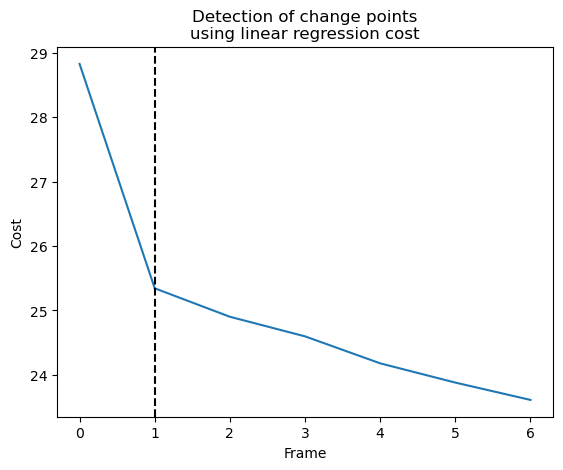

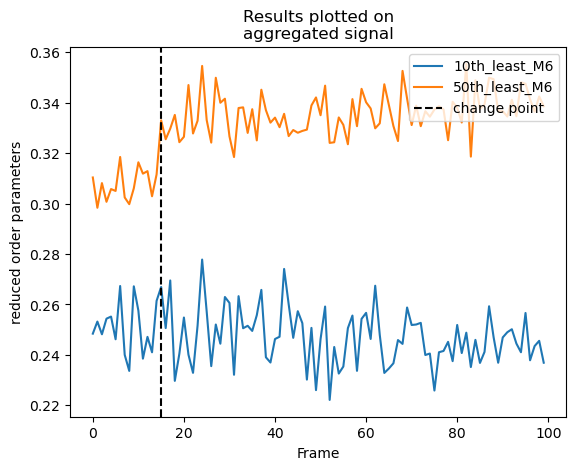

In [4]:
import warnings

import freud
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

import dupin as du

warnings.simplefilter("ignore")
ls = 6
FILENAME = "../data/lj-sim.xyz"


# custom generator function
def minkowski_generator(system):
    # compute voronoi neighbors and get nlist
    vor = freud.locality.Voronoi()
    vor.compute(system)
    nlist = vor.nlist
    # compute steinhardt
    steinhardt = freud.order.Steinhardt(l=ls, weighted=True)
    steinhardt.compute(system, neighbors=nlist)
    return {f"M{ls}": steinhardt.particle_order}


pipeline = du.data.base.CustomGenerator(minkowski_generator).pipe(
    du.data.reduce.NthGreatest((-10, -50))
)
signal_aggregator = du.data.aggregate.SignalAggregator(pipeline)
with open(FILENAME) as file:
    # Read the number of atoms
    N = int(file.readline().strip())
    # Read the comment line
    comment = file.readline().strip()
    box_params = float_list = [float(x) for x in comment.split()]
box_params = freud.Box.from_box(box_params)
traj = np.genfromtxt(FILENAME, skip_header=2, invalid_raise=False)[
    :, 1:4
].reshape(-1, N, 3)
box = freud.box.Box.cube(L=20)

for frame_positions in traj:
    signal_aggregator.accumulate((box, frame_positions))
lin_regress_cost = du.detect.CostLinearFit()
dynp = rpt.Dynp(custom_cost=lin_regress_cost)
sweep_detector = du.detect.SweepDetector(
    dynp, max_change_points=6, tolerance=0.001
)
change_points = sweep_detector.fit(signal_aggregator.to_dataframe())
plt.plot(sweep_detector.costs_)
plt.title("Detection of change points\nusing linear regression cost")
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.axvline(sweep_detector.opt_n_change_points_, color="k", linestyle="--")
plt.show()
# add change points as vlines
plt.plot(
    signal_aggregator.to_dataframe().to_numpy(),
    label=signal_aggregator.to_dataframe().columns.to_list(),
)
for change_point in change_points:
    plt.axvline(change_point, color="k", linestyle="--", label="change point")
plt.title("Results plotted on\naggregated signal")
plt.xlabel("Frame")
plt.ylabel("reduced order parameters")
plt.legend(loc="upper right")
plt.show()

## Other packages example
The custom generator function should accept a set of variables that will be used by the
custom generator. In case of freud this is a system tuple containing box and particle
coordinates. Custom generators can be used with other python packages which might
require different sets of variables for computation of order parameters/quantities. 